# Irish Sign Language Detection Using Transfer Learning
Anna Łukawska, Benny Fülöp, and Danée Knevel

This python notebook is created in order to assess the use of transfer learning for recoginising sign language characters using the Irish Sign Language dataset. 

The data used is downloaded from the following github repo and unzipped https://github.com/marlondcu/ISL/tree/master/Frames. 
The modelling was greatly informed by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


#### Loading Required Packages

In [1]:
import os
import re
import cv2
import pandas as pd
import numpy as np
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics
import uuid
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchinfo import summary
from tempfile import TemporaryDirectory

In [ ]:
#https://github.com/marlondcu/ISL/tree/d1d50bb65540b904e3e0a6ffe0997872c4e9e645/Frames
#https://github.com/marlondcu/ISL/tree/d1d50bb65540b904e3e0a6ffe0997872c4e9e645/Videos

In [ ]:
#git.Repo.clone_from(repo_url, destination_path)

#### Train Test Split

In [3]:
# Train and Test Split 
# Set the path to your Frames folder
frames_path = "ISL/Frames"

# Set the output path for train and test sets
train_path = os.path.join("ISL/SplitDataset", "train")
test_path = os.path.join("ISL/SplitDataset", "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the ratio for the train set for 80% it is a quicker than cross validation
train_ratio = 0.8

# Iterate through each person folder
for person_folder in os.listdir(frames_path):
    person_path = os.path.join(frames_path, person_folder)

    # Skip if it's not a directory
    if not os.path.isdir(person_path):
        continue

    # Create train and test folders for the person
    train_person_path = os.path.join(train_path, person_folder)
    test_person_path = os.path.join(test_path, person_folder)
    os.makedirs(train_person_path, exist_ok=True)
    os.makedirs(test_person_path, exist_ok=True)

    # Get the list of image files for the person
    image_files = [f for f in os.listdir(person_path) if f.endswith(".jpg")]

    # Randomly assign each image to the train or test set
    for image_file in image_files:
        if random.uniform(0, 1) < train_ratio:
            src_path = os.path.join(person_path, image_file)
            dst_path = os.path.join(train_person_path, image_file)
            shutil.copy(src_path, dst_path)
        else:
            src_path = os.path.join(person_path, image_file)
            dst_path = os.path.join(test_person_path, image_file)
            shutil.copy(src_path, dst_path)
    # tabulate the splits we ended up with
    print(f"Person {person_folder} - Train set: {len(os.listdir(train_person_path))}, Test set: {len(os.listdir(test_person_path))}")

    # We wrote this just in case to preserve the person information

Person Person1 - Train set: 7090, Test set: 1774
Person Person2 - Train set: 8006, Test set: 1965
Person Person3 - Train set: 7495, Test set: 1825
Person Person4 - Train set: 7681, Test set: 1870
Person Person5 - Train set: 9249, Test set: 2229
Person Person6 - Train set: 7141, Test set: 1789


#### Data Wrangling
This portion reformats the file paths in order to injest the data to pytorch

In [14]:
# helper function to pop subfolders
def pop_folder(folder_path): 
    contents = os.listdir(folder_path)
    
    for item in contents:
        item_path = os.path.join(folder_path, item)
        new_path = os.path.join(os.path.dirname(folder_path), item)
        
        shutil.move(item_path, new_path)
    shutil.rmtree(folder_path)
    
# regex to extract labels from file names    
pattern = r'-(\w)-'

# Extract the singular character between dashes for each file name so we have labels for the folders and a way to sort them
abcs = set([re.search(pattern, file_name).group(1) for file_name in os.listdir(os.path.join(train_path))])

# could create loop for train and test save some lines of code here
    
# Unwrapping the Person subfolders to get all the images in the train and test folders    
for subfolder in os.listdir(os.path.join(train_path)):
    pop_folder(os.path.join(os.path.join(train_path), subfolder))
    
for subfolder in os.listdir(os.path.join(test_path)):
    pop_folder(os.path.join(os.path.join(test_path), subfolder))


# Creat Subfolders in train and test with the label names
for value in abcs:
    folder_path = os.path.join(train_path, value)
    os.makedirs(folder_path, exist_ok=True)
    
for value in abcs:
    folder_path = os.path.join(test_path, value)
    os.makedirs(folder_path, exist_ok=True)
    

file_names = os.listdir(train_path)

# Move files to their corresponding folders
for file_name in file_names:
    match = re.search(pattern, file_name)
    if match:
        value = match.group(1)
        source_path = os.path.join(train_path, file_name)
        destination_path = os.path.join(train_path, value, file_name)
        
        # Ensure the destination folder exists before moving
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        
        shutil.move(source_path, destination_path)
        
file_names = os.listdir(test_path)

for file_name in file_names:
    match = re.search(pattern, file_name)
    if match:
        value = match.group(1)
        source_path = os.path.join(test_path, file_name)
        destination_path = os.path.join(test_path, value, file_name)

        # Ensure the destination folder exists before moving
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        shutil.move(source_path, destination_path)

In [3]:
# cell to run in case data wrangling had been done, just re asserts the 
train_path = os.path.join("ISL", "SplitDataset", "train")
test_path = os.path.join( "ISL", "SplitDataset", "test")

#### Setting up Data Loading and Transforms

In [53]:
data_transforms = {
    'train': v2.Compose([
        v2.RandomResizedCrop(224), # To deal with missing parts of the hand in the detection area
        v2.RandomHorizontalFlip(), # To deal with left and right hands, dataset only contains right hands
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)), # To adress image quality issues
        v2.RandomInvert(), # The images are black and white, this should allow the network to deal with white backgrounds, maybe differentiate the hands
        v2.RandomPerspective(distortion_scale=0.4, p=0.5), # To adress different angles of the images
        transforms.ToTensor(), # convert to tensor object
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # utilising the imagenet norms as we will use imagenet weights
    ]),
    'test': v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.RandomHorizontalFlip(p=0.5), # we utilise flipping in testing as well as it is reasonable for the sign to be left or right handed in real life as well
        transforms.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir =  os.path.join("ISL", "SplitDataset") # directory of the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']} # dict comprehension to set train and 

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=24)
              for x in ['train', 'test']} # creating the dataloaders and specifying batch size and number of cores ##### adjust if needed

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']} # get dataset sizes
class_names = image_datasets['train'].classes # get class labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # we trained on gpu

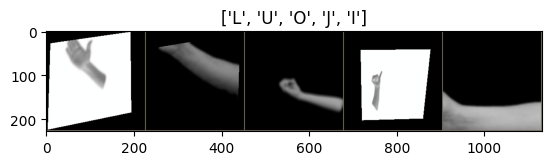

In [56]:
# Tabulating a batch of the data to see what we will train on

def imshow(inp, title=None):
    """Display image for Tensor."""
    #plt.figure(figsize=(20,10))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data 
inputs, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) 

imshow(out, title=[class_names[x] for x in classes])

#### Training

In [5]:
# defining train function
# this is from the pytorch tutorial

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    #print(labels)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

##### ResNet18 Architecture

In [8]:
model_res_18 = models.resnet18(weights='IMAGENET1K_V1') # pulling the resnet18 architecture with the weights from imagenet
num_ftrs = model_res_18.fc.in_features # getting the input features dimensions

model_res_18.fc = nn.Linear(num_ftrs,len(class_names)) #specifying the classification layer

model_ft = model_res_18.to(device) # sending the model to the gpu

criterion = nn.CrossEntropyLoss() # training criterion is cross entropy loss

# Observe that all parameters are being optimized 
optimizer_ft = optim.SGD(model_res_18.parameters(), lr=0.001, momentum=0.9) 

# Decay LR by a factor of 0.1 every 7 epochs to adjust learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1,verbose = True))

In [9]:
model_res_18 = train_model(model_res_18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.7720 Acc: 0.4592
test Loss: 0.3620 Acc: 0.8855

Epoch 1/9
----------
train Loss: 1.2564 Acc: 0.6153
test Loss: 0.1804 Acc: 0.9364

Epoch 2/9
----------
train Loss: 1.1345 Acc: 0.6526
test Loss: 0.1602 Acc: 0.9466

Epoch 3/9
----------
train Loss: 1.0538 Acc: 0.6771
test Loss: 0.0867 Acc: 0.9700

Epoch 4/9
----------
train Loss: 1.0093 Acc: 0.6901
test Loss: 0.1193 Acc: 0.9579

Epoch 5/9
----------
train Loss: 0.9787 Acc: 0.7006
test Loss: 0.0805 Acc: 0.9743

Epoch 6/9
----------
train Loss: 0.9616 Acc: 0.7042
test Loss: 0.0597 Acc: 0.9804

Epoch 7/9
----------
train Loss: 0.8875 Acc: 0.7307
test Loss: 0.0457 Acc: 0.9839

Epoch 8/9
----------
train Loss: 0.8696 Acc: 0.7348
test Loss: 0.0369 Acc: 0.9884

Epoch 9/9
----------
train Loss: 0.8524 Acc: 0.7396
test Loss: 0.0315 Acc: 0.9908

Training complete in 21m 50s
Best test Acc: 0.990831


In [12]:
torch.save(model_res_18.state_dict(), os.path.join( , resnet18_10_aug.pt") #saving the model 

#### ResNet18 Architecture Re-load model

In [3]:
# Instantiate the model
model_res_18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_res_18.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_18.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\resnet18_10_aug.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_18.load_state_dict(state_dict)

<All keys matched successfully>

##### ResNet 50 Architecture

In [6]:
model_res_50 = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_res_50.fc.in_features

model_res_50.fc = nn.Linear(num_ftrs,len(class_names))

model_res_50 = model_res_50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized~
optimizer_ft = optim.SGD(model_res_50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1, verbose = True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [7]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model_res_50 = train_model(model_res_50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.6998 Acc: 0.4915
test Loss: 0.2352 Acc: 0.9241

Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.1395 Acc: 0.6530
test Loss: 0.1282 Acc: 0.9609

Epoch 2/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.0313 Acc: 0.6848
test Loss: 0.0930 Acc: 0.9687

Epoch 3/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.9205 Acc: 0.7204
test Loss: 0.0523 Acc: 0.9838

Epoch 4/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.8864 Acc: 0.7289
test Loss: 0.0516 Acc: 0.9831

Epoch 5/9
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.8898 Acc: 0.7296
test Loss: 0.0511 Acc: 0.9836

Epoch 6/9
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.8699 Acc: 0.7352
test Loss: 0.0445 Acc: 0.9852

Epoch 7/9
----------
Adjusting learning rate of group 0 to 1.0000e-05

In [8]:
torch.save(model_res_50.state_dict(), r"C:\Users\azabe\Desktop\Masters\AppliedAI\resnet50_10_aug.pt")

#### ResNet50 Architecture Re-Load

In [4]:
# Instantiate the model
model_res_50 = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_res_50.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_50.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\resnet50_10_aug.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_50.load_state_dict(state_dict)

<All keys matched successfully>

##### ResNet 101 Architecture

In [52]:
model_res_101 = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_res_101.fc.in_features

model_res_101.fc = nn.Linear(num_ftrs,len(class_names))

model_res_101 = model_res_101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized~
optimizer_ft = optim.SGD(model_res_101.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1, verbose = True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\azabe/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:14<00:00, 12.5MB/s] 


Adjusting learning rate of group 0 to 1.0000e-03.


In [54]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model_res_101 = train_model(model_res_101, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.1167 Acc: 0.6588
test Loss: 0.1308 Acc: 0.9524

Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.0094 Acc: 0.6907
test Loss: 0.1188 Acc: 0.9564

Epoch 2/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.8957 Acc: 0.7267
test Loss: 0.0560 Acc: 0.9798

Epoch 3/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.8792 Acc: 0.7305
test Loss: 0.0456 Acc: 0.9845

Epoch 4/9
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.8398 Acc: 0.7443
test Loss: 0.0435 Acc: 0.9857

Epoch 5/9
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.8401 Acc: 0.7436
test Loss: 0.0416 Acc: 0.9862

Epoch 6/9
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.8358 Acc: 0.7453
test Loss: 0.0420 Acc: 0.9865

Epoch 7/9
----------
Adjusting learning rate of group 0 to 1.0000e-06

In [55]:
torch.save(model_res_101.state_dict(), r"C:\Users\azabe\Desktop\Masters\AppliedAI\resnet101_10_aug.pt")

#### ResNet 101 Architecture Re-Load

In [5]:
# Instantiate the model
model_res_101 = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_res_101.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_101.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\resnet101_10_aug.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_101.load_state_dict(state_dict)

<All keys matched successfully>

##### ResNet18 as feature extractor 

In [10]:
model_res_18_l = models.resnet18(weights='IMAGENET1K_V1')
for param in model_res_18_l.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_res_18_l.fc.in_features
model_res_18_l.fc = nn.Linear(num_ftrs, len(class_names))

model_res_18_l = model_res_18_l.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fe = optim.SGD(model_res_18_l.fc.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=3, gamma=0.1, verbose = True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [11]:
model_res_18_l= train_model(model_res_18_l, criterion, optimizer_fe, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 2.9155 Acc: 0.1711
test Loss: 2.2564 Acc: 0.2979

Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 2.7058 Acc: 0.2291
test Loss: 2.0205 Acc: 0.3588

Epoch 2/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.6646 Acc: 0.2402
test Loss: 1.9677 Acc: 0.3823

Epoch 3/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.4678 Acc: 0.2827
test Loss: 1.7902 Acc: 0.4358

Epoch 4/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.4535 Acc: 0.2903
test Loss: 1.8038 Acc: 0.4319

Epoch 5/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 2.4489 Acc: 0.2908
test Loss: 1.7621 Acc: 0.4538

Epoch 6/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 2.4237 Acc: 0.2993
test Loss: 1.7672 Acc: 0.4505

Epoch 7/9
----------
Adjusting learning rate of group 0 to 1.0000e-04

In [12]:
torch.save(model_res_18_l.state_dict(), r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_18_l.pt")

#### ResNet18 as feature extractor Re-Load

In [7]:
# Instantiate the model
model_res_18_l = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_res_18_l.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_18_l.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_18_l.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_18_l.load_state_dict(state_dict)

<All keys matched successfully>

##### ResNet50 as feature extractor 

In [19]:
model_res_50_l = models.resnet50(weights='IMAGENET1K_V1')
for param in model_res_50_l.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_res_50_l.fc.in_features
model_res_50_l.fc = nn.Linear(num_ftrs, len(class_names))

model_res_50_l = model_res_50_l.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fe = optim.SGD(model_res_50_l.fc.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=3, gamma=0.1, verbose = True)

In [21]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model_res_50_l= train_model(model_res_50_l, criterion, optimizer_fe, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.8312 Acc: 0.2005
test Loss: 1.9983 Acc: 0.3914

Epoch 1/9
----------
train Loss: 2.7340 Acc: 0.2262
test Loss: 1.9950 Acc: 0.3709

Epoch 2/9
----------
train Loss: 2.7144 Acc: 0.2340
test Loss: 2.1773 Acc: 0.3353

Epoch 3/9
----------
train Loss: 2.6883 Acc: 0.2400
test Loss: 1.9026 Acc: 0.4053

Epoch 4/9
----------
train Loss: 2.6600 Acc: 0.2477
test Loss: 1.8347 Acc: 0.4276

Epoch 5/9
----------
train Loss: 2.6329 Acc: 0.2531
test Loss: 1.8490 Acc: 0.4200

Epoch 6/9
----------
train Loss: 2.6005 Acc: 0.2635
test Loss: 1.7657 Acc: 0.4439

Epoch 7/9
----------
train Loss: 2.4311 Acc: 0.3002
test Loss: 1.6734 Acc: 0.4849

Epoch 8/9
----------
train Loss: 2.4284 Acc: 0.3006
test Loss: 1.6856 Acc: 0.4878

Epoch 9/9
----------
train Loss: 2.4173 Acc: 0.3029
test Loss: 1.6717 Acc: 0.4872

Training complete in 32m 18s
Best test Acc: 0.487775


In [22]:
torch.save(model_res_50_l.state_dict(), r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_50_l.pt")

#### ResNet50 as feature extractor Re-Load

In [6]:
# Instantiate the model
model_res_50_l = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_res_50_l.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_50_l.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_50_l.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_50_l.load_state_dict(state_dict)

<All keys matched successfully>

##### ResNet101 as feature extractor 

In [59]:
model_res_101_l = models.resnet101(weights='IMAGENET1K_V1')
for param in model_res_101_l.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_res_101_l.fc.in_features
model_res_101_l.fc = nn.Linear(num_ftrs, len(class_names))

model_res_101_l = model_res_101_l.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fe = optim.SGD(model_res_101_l.fc.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=3, gamma=0.1, verbose = True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [60]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model_res_101_l= train_model(model_res_101_l, criterion, optimizer_fe, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 2.9061 Acc: 0.1776
test Loss: 2.1546 Acc: 0.3148

Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 2.7187 Acc: 0.2298
test Loss: 2.0695 Acc: 0.3702

Epoch 2/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.6669 Acc: 0.2461
test Loss: 1.9569 Acc: 0.3590

Epoch 3/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.4339 Acc: 0.2971
test Loss: 1.7898 Acc: 0.4335

Epoch 4/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 2.4324 Acc: 0.2963
test Loss: 1.7604 Acc: 0.4509

Epoch 5/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 2.4184 Acc: 0.3022
test Loss: 1.7804 Acc: 0.4397

Epoch 6/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 2.3988 Acc: 0.3088
test Loss: 1.7612 Acc: 0.4497

Epoch 7/9
----------
Adjusting learning rate of group 0 to 1.0000e-04

In [61]:
torch.save(model_res_101_l.state_dict(), r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_101_l.pt")

#### ResNet101 as feature extractor Re-Load

In [8]:
# Instantiate the model
model_res_101_l = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_res_101_l.fc.in_features
# Modify the final fully connected layer to match the number of classes in the loaded state_dict
num_classes = 26
model_res_101_l.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes)

# Load the state dictionary from the file
state_dict = torch.load(r"C:\Users\azabe\Desktop\Masters\AppliedAI\model_res_101_l.pt", map_location='cpu')

# Load the state dictionary into the model
model_res_101_l.load_state_dict(state_dict)

<All keys matched successfully>

#### Model evaluation 

##### Tables of Accuracy

In [16]:
model_names = ['model_res_101_l', 'model_res_50_l', 'model_res_18_l', 'model_res_101', 'model_res_50', 'model_res_18']

# Initialize a list to store accuracy scores
accuracy_scores = []

model_res_101_l.to(device)
model_res_50_l.to(device)
model_res_18_l.to(device)
model_res_101.to(device)
model_res_50.to(device)
model_res_18.to(device)

# Function to evaluate a model and return accuracy
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    accuracy = metrics.accuracy_score(true_labels, predicted_labels)
    return accuracy

# Evaluate each model and store accuracy scores
for model in [model_res_101_l, model_res_50_l, model_res_18_l, model_res_101, model_res_50, model_res_18]:
    accuracy = evaluate_model(model, dataloaders['test'])
    accuracy_scores.append(accuracy)

# Create a table
table_data = list(zip(model_names, accuracy_scores))
table_headers = ["Model Name", "Accuracy"]
table = tabulate(table_data, headers=table_headers, tablefmt="grid")

# Print the table
print(table)

+-----------------+------------+
| Model Name      |   Accuracy |
+=================+============+
| model_res_101_l |   0.455117 |
+-----------------+------------+
| model_res_50_l  |   0.48437  |
+-----------------+------------+
| model_res_18_l  |   0.454942 |
+-----------------+------------+
| model_res_101   |   0.988736 |
+-----------------+------------+
| model_res_50    |   0.985854 |
+-----------------+------------+
| model_res_18    |   0.990482 |
+-----------------+------------+


Code to creat validation set easily 

In [ ]:
#  this, this is the code we used to create our own validation set
path = os.path.join("ISL", "Validation") # where we write the results

# parameters of the image capture
abcs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
num_img = 11 # number of images to caputre, had to use 11 as on my system it takes a frame to initialise the camera

for label in abcs:
    os.makedirs(os.path.join(path, label), exist_ok=True)
    cap = cv2.VideoCapture(0)
    print(f"Recording images for {label}") # show what we will record
    time.sleep(5) # time between recordings
    for imgnum in range(num_img):
        ret, frame = cap.read()
        imagename = os.path.join(path, label, "."+"{}.jpg".format(str(uuid.uuid1()))) # generate unique file names
        cv2.imwrite(imagename, frame)
        cv2.imshow("frame", frame)
        time.sleep(2) # give time to move between captures
        
        if cv2.waitKey(1) && 0xFF == ord(q): # quit criterion to exit the program
            break
    cap.release()

Open validation set, transform it the same way we transformed the test set to keep things fair and create data loader for prediction

In [57]:
eval_path = os.path.join("ISL", "Our pictures (1)-20240117T150704Z-001","Our pictures (1)")

# Define the evaluation data transform
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create an evaluation dataset
eval_dataset = datasets.ImageFolder(eval_path, eval_transform)

# Create an evaluation dataloader
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=30, shuffle=True, num_workers=24)


In [44]:
# Evaluate each model on the evaluation set
eval_accuracy_scores = []

for model in [model_res_101_l, model_res_50_l, model_res_18_l, model_res_101, model_res_50, model_res_18]:
    accuracy = evaluate_model(model, eval_dataloader)
    eval_accuracy_scores.append(accuracy)

# Create a table for evaluation results
eval_table_data = list(zip(model_names, eval_accuracy_scores))
eval_table_headers = ["Model Name", "Accuracy"]
eval_table = tabulate(eval_table_data, headers=eval_table_headers, tablefmt="grid")

# Print the evaluation table
print("Evaluation Results:")
print(eval_table)

Evaluation Results:
+-----------------+------------+
| Model Name      |   Accuracy |
+=================+============+
| model_res_101_l |  0.0373134 |
+-----------------+------------+
| model_res_50_l  |  0.0410448 |
+-----------------+------------+
| model_res_18_l  |  0.0447761 |
+-----------------+------------+
| model_res_101   |  0.597015  |
+-----------------+------------+
| model_res_50    |  0.61194   |
+-----------------+------------+
| model_res_18    |  0.447761  |
+-----------------+------------+


#### Visualising model results

In [40]:
def visualize_model(model, num_images=6, test_data = dataloaders['test']):  # checking the categorisation via testing on some images
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            #print(outputs) for checking the output 
            _, preds = torch.max(outputs, 1)
            

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

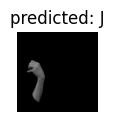

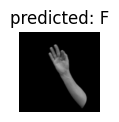

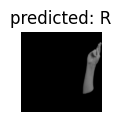

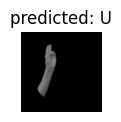

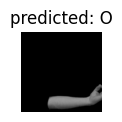

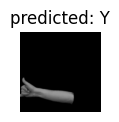

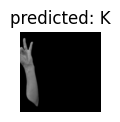

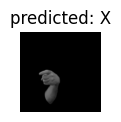

In [41]:
visualize_model(model_res_50, 8, dataloaders['test']) # the best model the fully trained ResNet50 seem to perform very well on the test set

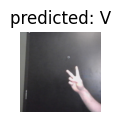

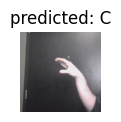

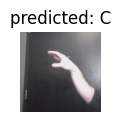

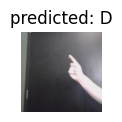

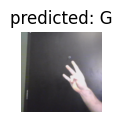

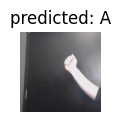

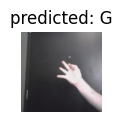

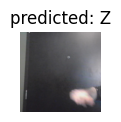

In [47]:
visualize_model(model_res_50, 8, eval_dataloader) # The model correctly classifies some signs and struggles with others on data that it hasn't seen

##### Plotting Confusion Matrices 

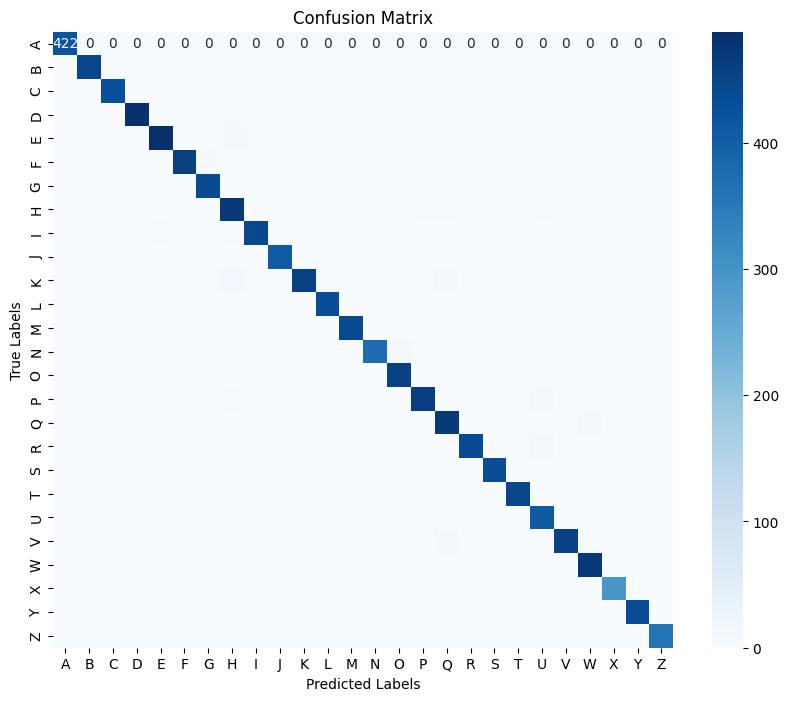

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       422
           B       1.00      1.00      1.00       449
           C       1.00      1.00      1.00       428
           D       1.00      0.98      0.99       496
           E       0.99      0.98      0.99       497
           F       1.00      0.98      0.99       467
           G       0.98      1.00      0.99       438
           H       0.95      0.98      0.96       483
           I       1.00      0.99      0.99       452
           J       1.00      1.00      1.00       407
           K       1.00      0.97      0.98       471
           L       1.00      1.00      1.00       434
           M       1.00      1.00      1.00       441
           N       1.00      0.96      0.98       388
           O       0.97      1.00      0.99       455
           P       0.97      0.98      0.98       470
           Q       0.95      0.98      0.97       478
    

In [23]:
# Set the model to evaluation mode
model_res_101.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test set and make predictions
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_res_101(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate overall accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {accuracy}")

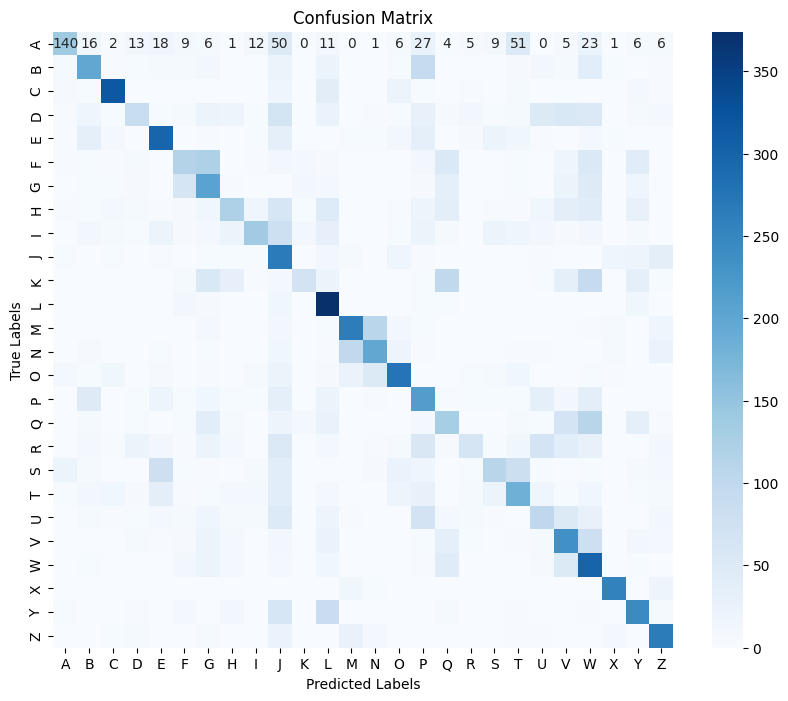

Classification Report:
              precision    recall  f1-score   support

           A       0.68      0.33      0.45       422
           B       0.50      0.44      0.47       449
           C       0.80      0.74      0.77       428
           D       0.49      0.18      0.26       496
           E       0.56      0.60      0.58       497
           F       0.42      0.24      0.31       467
           G       0.33      0.47      0.39       438
           H       0.45      0.25      0.32       483
           I       0.63      0.30      0.41       452
           J       0.26      0.66      0.37       407
           K       0.61      0.15      0.24       471
           L       0.46      0.86      0.60       434
           M       0.59      0.60      0.59       441
           N       0.51      0.51      0.51       388
           O       0.64      0.61      0.62       455
           P       0.33      0.46      0.38       470
           Q       0.27      0.27      0.27       478
    

In [24]:
# Set the model to evaluation mode
model_res_101_l.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test set and make predictions
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_res_101_l(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate overall accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {accuracy}")

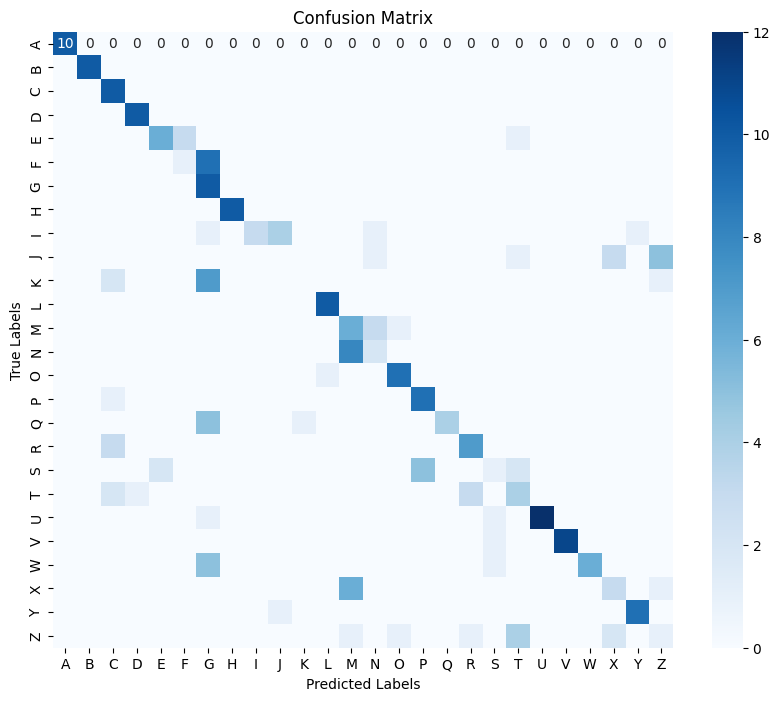

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           B       1.00      1.00      1.00        10
           C       0.56      1.00      0.71        10
           D       0.91      1.00      0.95        10
           E       0.75      0.60      0.67        10
           F       0.25      0.10      0.14        10
           G       0.26      1.00      0.42        10
           H       1.00      1.00      1.00        10
           I       1.00      0.30      0.46        10
           J       0.00      0.00      0.00        10
           K       0.00      0.00      0.00        10
           L       0.91      1.00      0.95        10
           M       0.29      0.60      0.39        10
           N       0.29      0.20      0.24        10
           O       0.82      0.90      0.86        10
           P       0.64      0.90      0.75        10
           Q       1.00      0.40      0.57        10
    

In [52]:
# Set the model to evaluation mode
model_res_50.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test set and make predictions
with torch.no_grad():
    for inputs, labels in eval_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_res_50(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate overall accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {accuracy}")

In [26]:
summary(model_res_50) # tabulate the best architecture

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

#### Real time recognition

In [ ]:
cap = cv2.VideoCapture(0) # Detect signs in real time

cap.set(3, 700) # setting the dimensions of the capture
cap.set(4, 480)

signs = class_names

while True:
    ret, frame = cap.read()

    img = frame[20:250, 20:250] # the image capture dimensions

    res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC) # resizing 
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) # set the color to black and white

    res1 = np.reshape(res, (1, 1, 28, 28)) / 255 # fit the dimensions of the training data
    res1 = np.repeat(res1, 3, axis=1)
    res1 = torch.from_numpy(res1) # create numpy array
    res1 = res1.type(torch.FloatTensor) # create tensor
    
    model_res_50.eval() # set model to evaluation mode

    out = model_res_50(res1) #get probabilities
    # Probabilites 
    probs, label = torch.topk(out, 25)
    probs = torch.nn.functional.softmax(probs, 1)  
    #print(out)

    wht, pred = torch.max(out, 1) # predict label
    #print(wht)
    #print(pred)

    if float(probs[0,0]) < 0.4:
        texto_mostrar = 'Sign not detected'
    else:
        texto_mostrar = signs[int(pred)] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, texto_mostrar, (60,285), font, 1, (255,0,0), 2, cv2.LINE_AA)

    frame = cv2.rectangle(frame, (20, 20), (250, 250), (0, 255, 0), 3)

    cv2.imshow('Cam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
